# Imports and setup

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D

from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs

# 1-Dimensional case:
The equation is:

$$
\left[-\frac{1}{2}(D) + mL^2 V \right] \psi = \left(m L^2 E\right) \psi
$$

where $D$ has -2 on the main diagonal and 1 on the two neighbouring diagonals. This is a matrix aproximation of the second derivative.
$\psi$ is the state vector. 

The potential function returns the potential energy at a given position in units of $mL^2$.

I will define a variaty of potential functions to test the code.

In [164]:
# Define the grid
def define_grid(N):
	return np.linspace(0, 1, N)		# x grid

In [165]:
# Zero everywhere
def null_potential(N):
	return np.zeros(N)

# Square potential
#     if intensity > 0, the potential is a barrier
#     if intensity < 0, the potential is a well
def square_potential(N, pos=(2/5, 3/5), intensity=1):

	V = np.zeros(N)
	V[int(N*pos[0]):int(N*pos[1])] = intensity

	return V

# Gaussian potential
def gaussian_potential(N, pos=0.3, intensity=1, sigma=0.1):

	x = np.linspace(0, 1, N)
	V = intensity * np.exp(-((x - pos)**2)/(2*sigma**2))

	return V

We can express the equation as:
$$
H = T + U
$$

Then:
$$
T = -\frac{1}{2}D
$$
$$
U = 2m L^2 V
$$

In [166]:
def hamiltonian(N, V):
	# Define a vector of 1s with N points
	diag_ones = np.ones([N])
	# Define the diagonals of the matrix
	diags = np.array([diag_ones, -2*diag_ones, diag_ones])

	D_matrix = sparse.spdiags(diags, np.array([-1, 0, 1]), N, N)

	# Define T, U and H
	T = -0.5 * D_matrix
	U = sparse.diags(V)
	H = T + U

	return H

Compute the eigenvectors and eigenvalues

In [167]:
def compute_eigens(H, k):
	# Compute the eigenvalues and eigenvectors
	eigenvalues, eigenvectors = eigsh(H, k=k, which='SM')
	return eigenvalues, eigenvectors

In [168]:
# Define a function to get the eigen-vectots
def get_e(eigenvectors, n):
	return eigenvectors[:, n]

In [169]:
def plot_phi_V(X, V, eigen_vectors):
	plt.figure(figsize=(8, 5))
	plt.plot(X, V, label='Potential')
	for i, eigen_vector in enumerate(eigen_vectors.T):
		plt.plot(X, eigen_vector**2, label=f'#{i}')
	plt.legend()
	plt.xlabel('x')

In [170]:
def degeneracy(eigenvalues, tolerance=0.001):

	# Normalize the eigenvalues so the tolerance is relative
	eigenvalues_normalized = eigenvalues / np.linalg.norm(eigenvalues)
	
	for i, e1 in enumerate(eigenvalues_normalized):
		for j, e2 in enumerate(eigenvalues_normalized):
			if i != j and np.abs(e1 - e2) < tolerance:
				print(f'Degenerate states: {i} and {j}')

In [171]:
def simulate(N, potential_type, intensity=0.02, n_eigen=10):
	X = define_grid(N)

	if potential_type == 'square':
		V = square_potential(N, intensity=intensity)
	elif potential_type == 'gaussian':
		V = gaussian_potential(N, intensity=intensity)
	else:
		V = null_potential(N)

	H = hamiltonian(N, V)
	eigenvalues, eigenvectors = compute_eigens(H, k=n_eigen)

	plot_phi_V(X, V, eigenvectors)

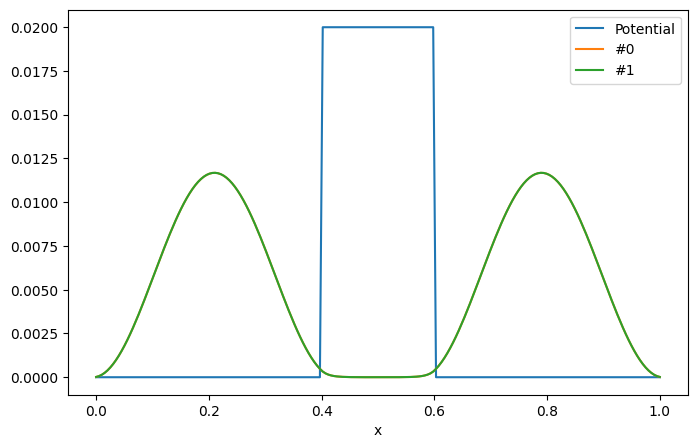

In [172]:
simulate(N=200, potential_type='square', intensity=0.02, n_eigen=2)

In [173]:
def normalize_potential(V):
	return V / np.linalg.norm(V)

def integ_potential(V):
	return sum(V)/len(V)

vector = np.array([1, 1, 1, 1, 1])
integ_potential(vector)

1.0

In [177]:
N = 200
X = define_grid(N)
V_0 = 0.01
V_null = null_potential(N)
V_square = square_potential(N, intensity=V_0)
V_well = square_potential(N, intensity=-V_0)
V_gaussian = gaussian_potential(N, intensity=V_0)

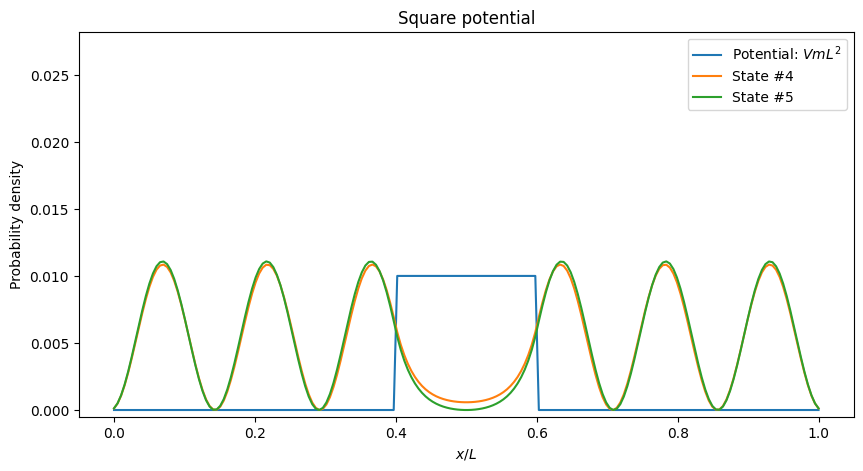

In [236]:
V = V_square
H = hamiltonian(N, V)
eigenvalues, eigenvectors = compute_eigens(H, k=10)
index = 4
fig = plt.figure(figsize=(10, 5))
plt.plot(X, V, label='Potential: $VmL^2$')
plt.plot(X, eigenvectors[:, index]**2, label=f'State #{index}')
plt.plot(X, eigenvectors[:, index+1]**2, label=f'State #{index+1}')
plt.ylim(-0.0005, np.max(eigenvectors**2)*1.1)
# plt.ylim(-np.max(eigenvectors)*1.1, np.max(eigenvectors)*1.1)
plt.title('Square potential')
plt.xlabel('$x/L$')
plt.ylabel('Probability density')
plt.legend()

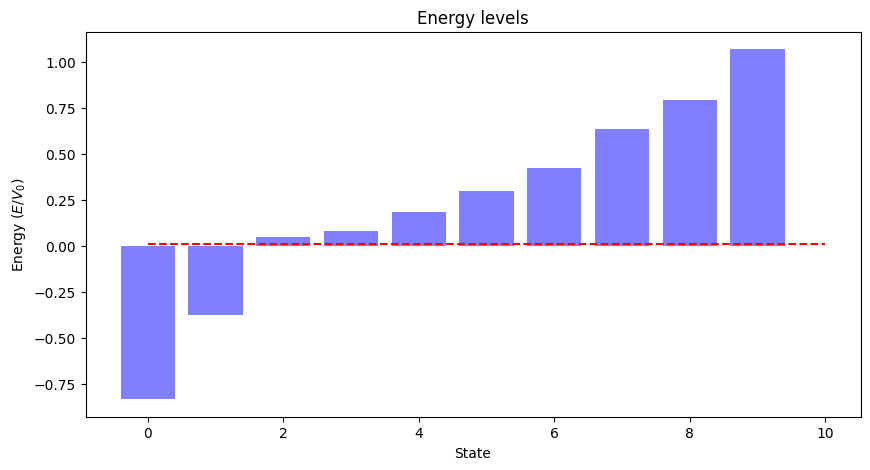

In [251]:
def eigenenergy_plot(eigenvalues, norm_constant, V_0):	
# Plot the energy levels
	plt.figure(figsize=(10, 5))
	plt.bar(range(len(eigenvalues)), eigenvalues/norm_constant, color='blue', alpha=0.5)
	plt.hlines(V_0, 0, len(eigenvalues), linestyle='--', color='red')
	plt.title('Energy levels')
	plt.xlabel('State')
	plt.ylabel('Energy ($E/V_0$)')
	# plt.xticks(range(len(eigenvalues)))

eigenenergy_plot(eigenvalues, V_0, V_0)

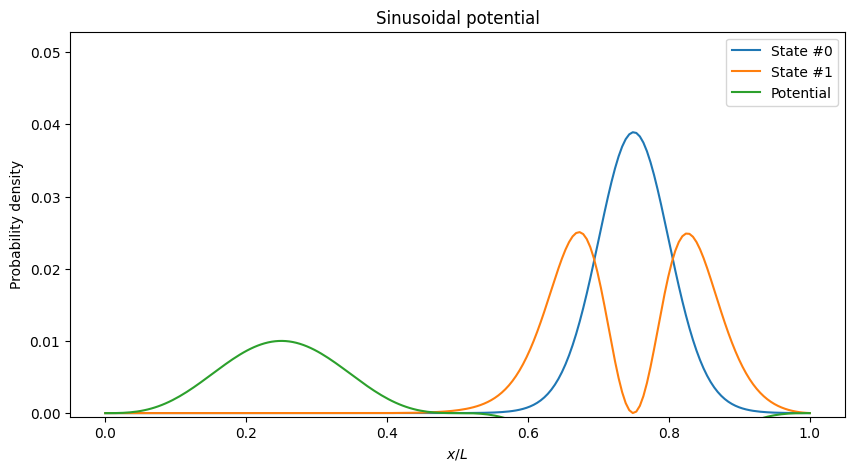

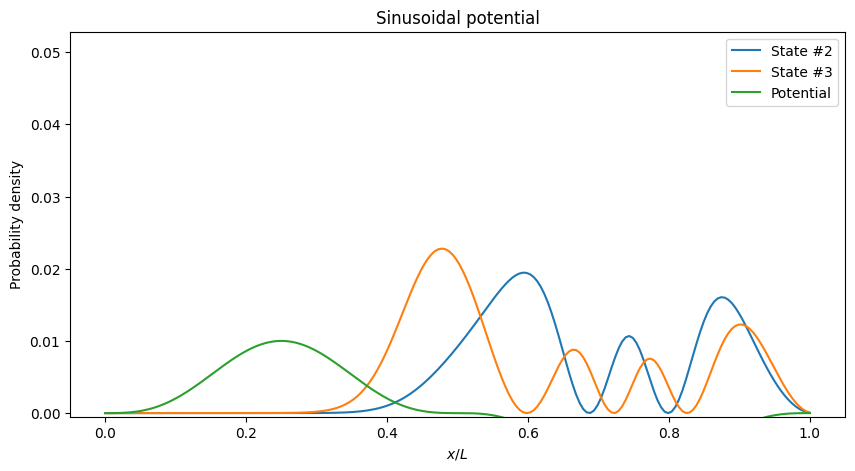

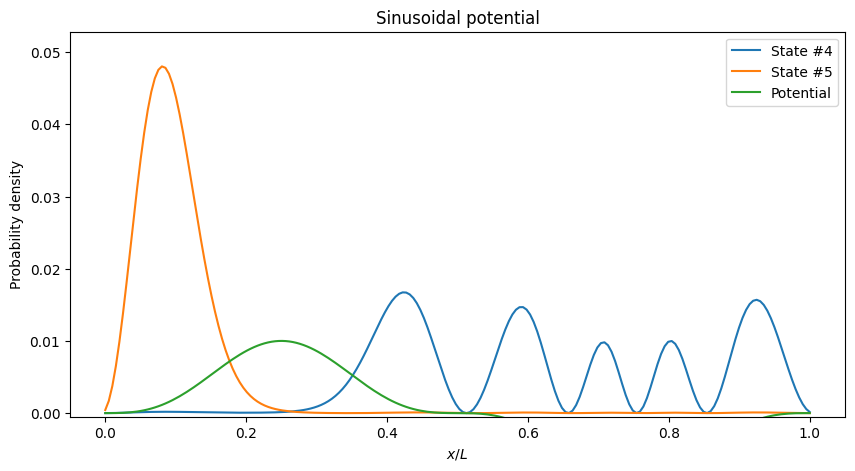

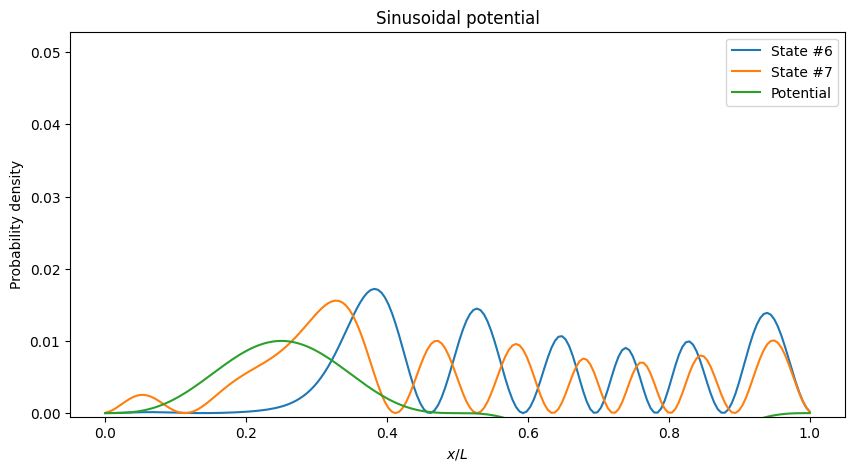

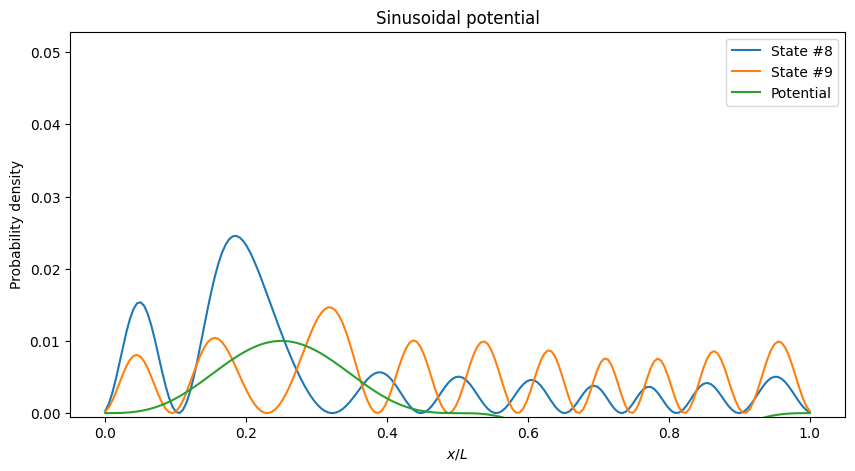

In [206]:
N = 200
X = define_grid(N)
V_0 = 0.01
V = V_0*np.sin(2*np.pi*X)**3

H = hamiltonian(N, V)
eigenvalues, eigenvectors = compute_eigens(H, k=10)
for index in range(0, len(eigenvalues), 2):
	fig = plt.figure(figsize=(10, 5))
	plt.plot(X, eigenvectors[:, index]**2, label=f'State #{index}')
	plt.plot(X, eigenvectors[:, index+1]**2, label=f'State #{index+1}')
	plt.plot(X, V, label='Potential')
	plt.ylim(-0.0005, np.max(eigenvectors**2)*1.1)
	plt.title('Sinusoidal potential')
	plt.xlabel('$x/L$')
	plt.ylabel('Probability density')
	plt.legend()

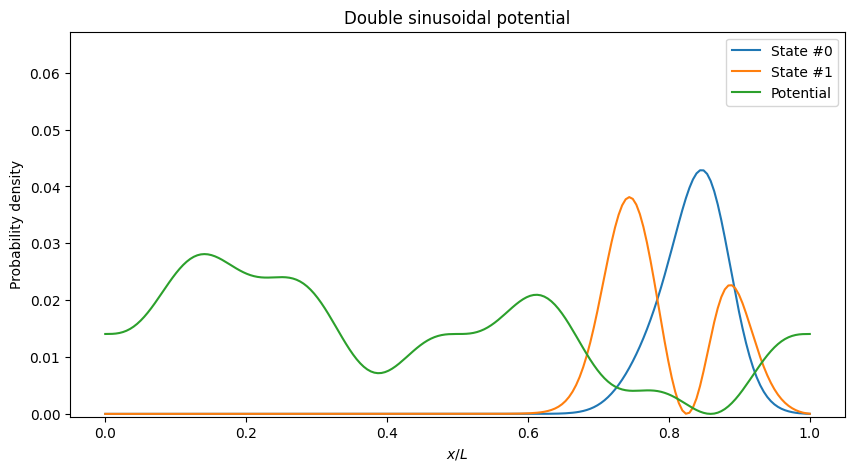

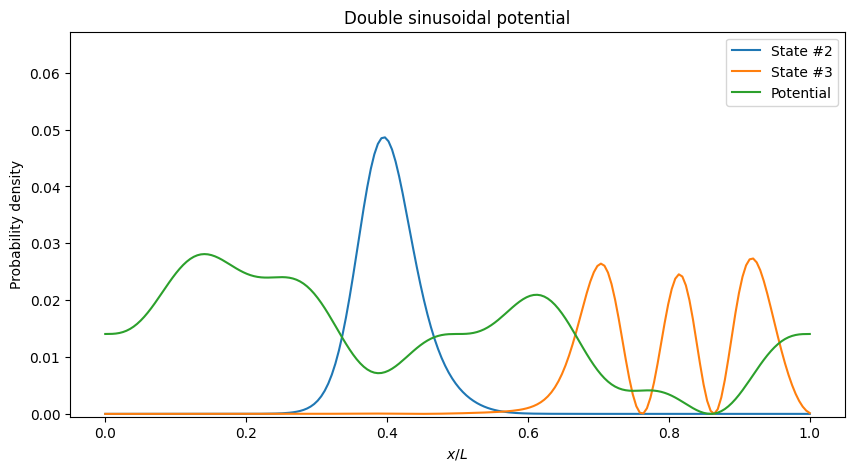

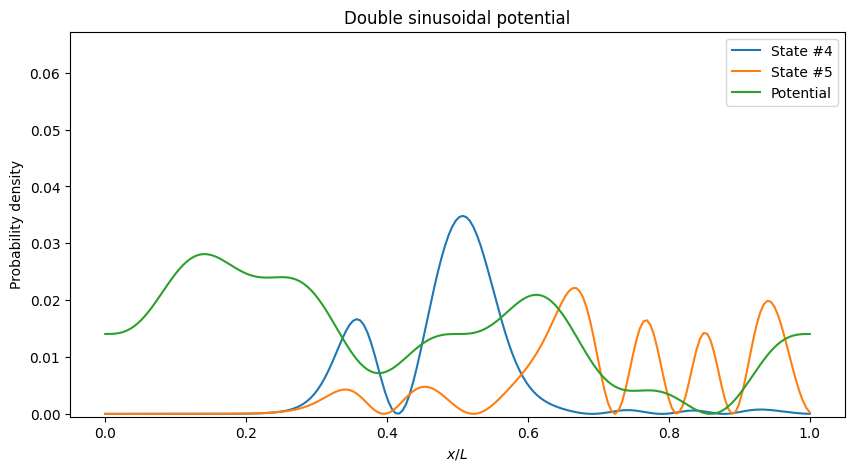

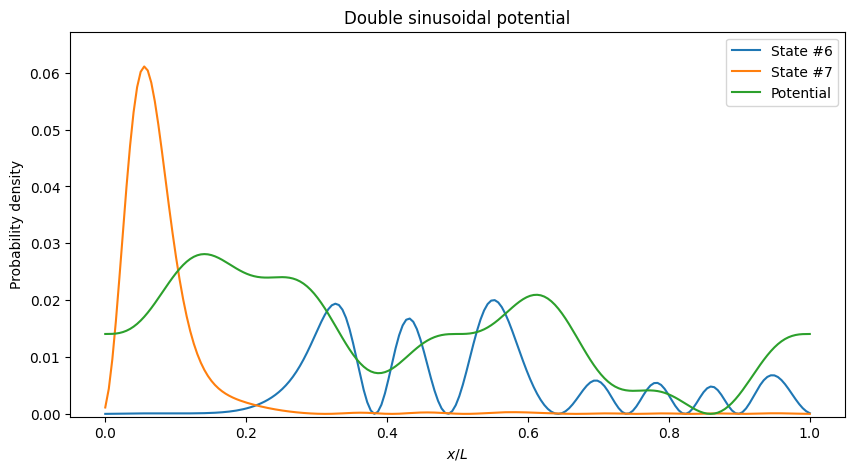

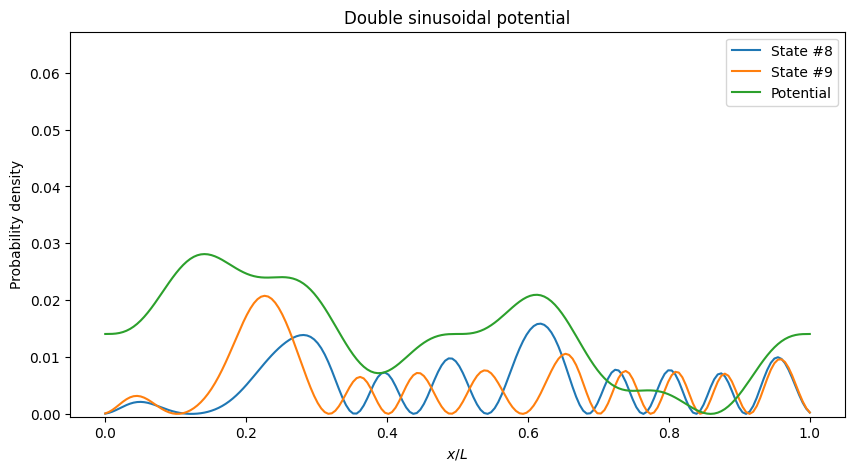

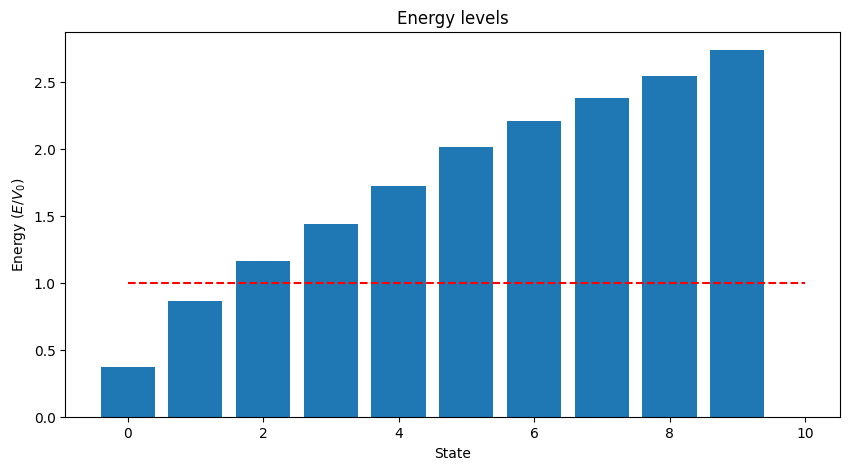

In [238]:
def double_potential(X, V_0=0.01):
	V = V_0*np.sin(2*np.pi*X)**3 + V_0*np.sin(4*np.pi*X)**3
	return V - np.min(V)

N = 200
X = define_grid(N)
V = double_potential(X)

H = hamiltonian(N, V)
eigenvalues, eigenvectors = compute_eigens(H, k=10)
for index in range(0, len(eigenvalues), 2):
	fig = plt.figure(figsize=(10, 5))
	plt.plot(X, eigenvectors[:, index]**2, label=f'State #{index}')
	plt.plot(X, eigenvectors[:, index+1]**2, label=f'State #{index+1}')
	plt.plot(X, V, label='Potential')
	plt.ylim(-0.0005, np.max(eigenvectors**2)*1.1)
	plt.title('Double sinusoidal potential')
	plt.xlabel('$x/L$')
	plt.ylabel('Probability density')
	plt.legend()
	

eigenenergy_plot(eigenvalues, V_0)

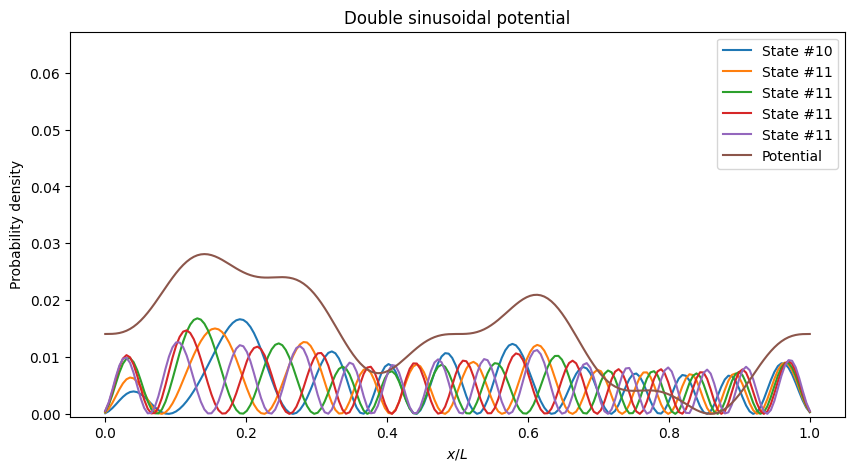

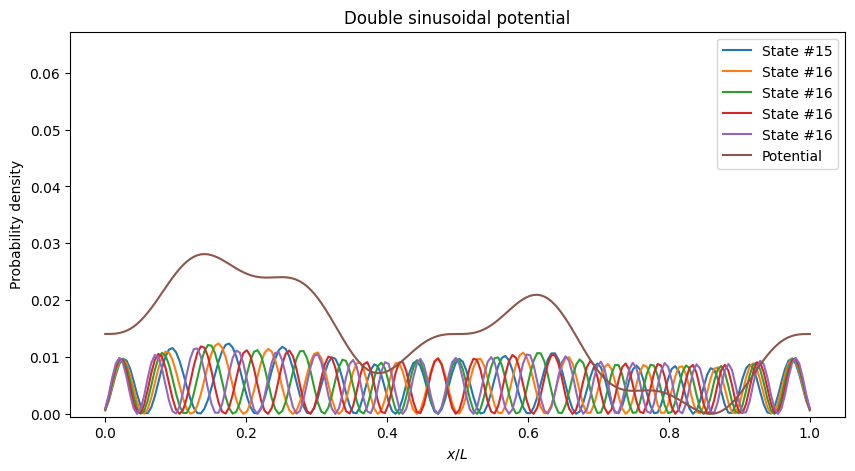

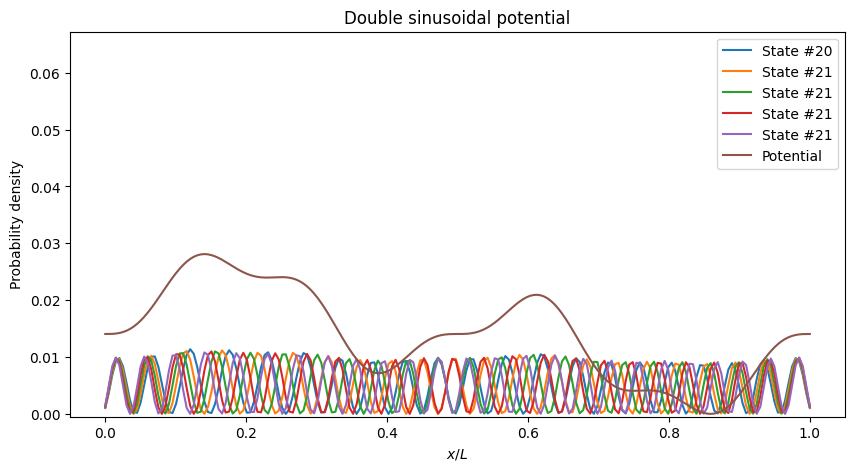

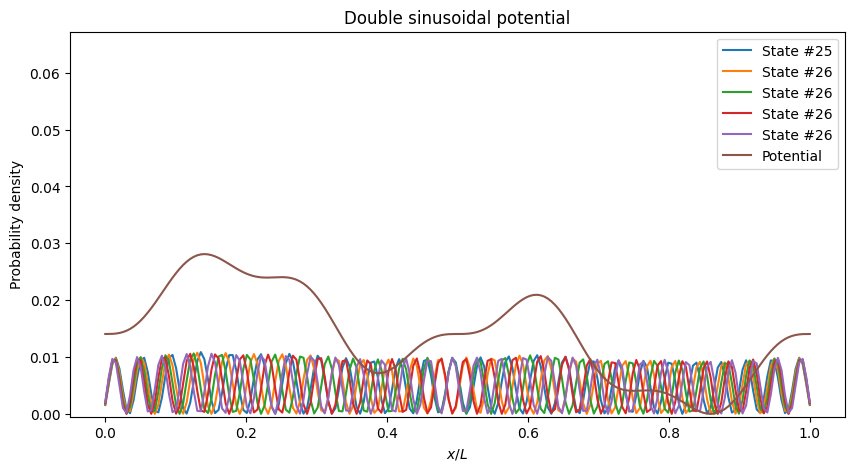

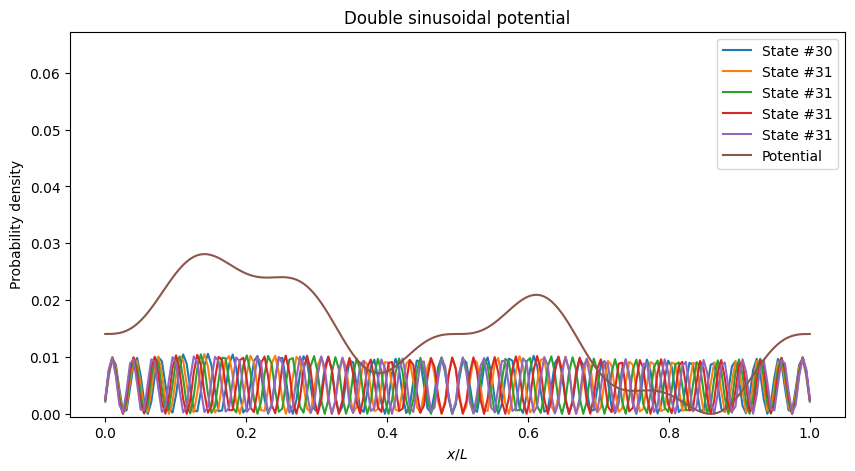

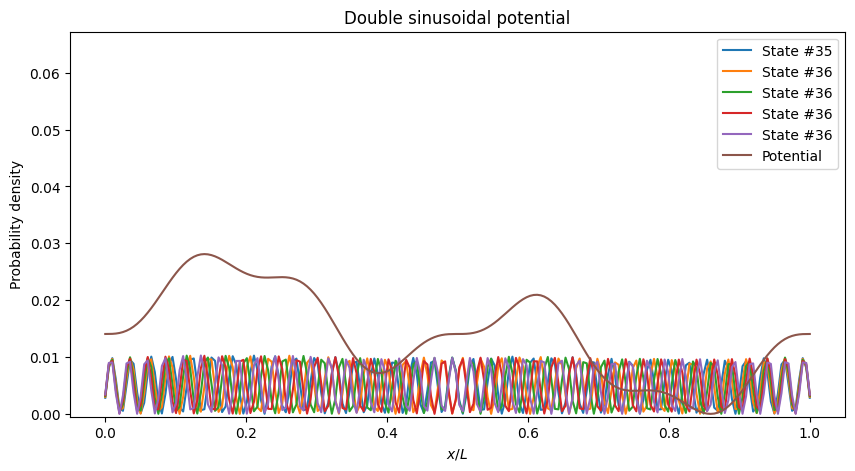

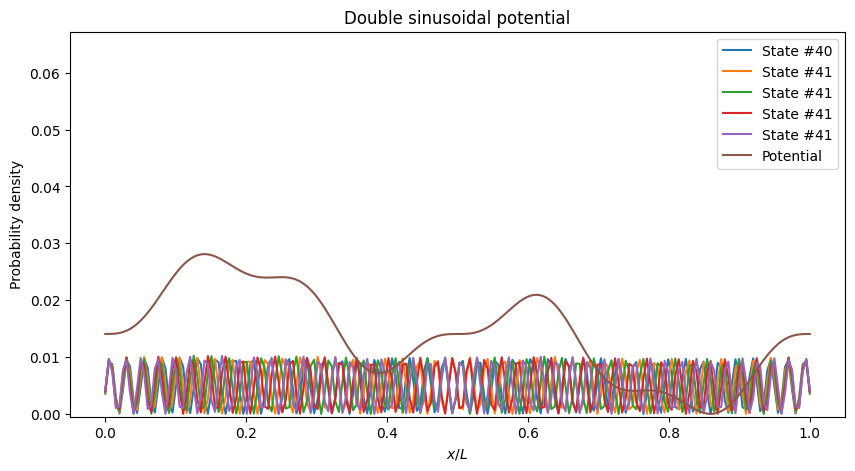

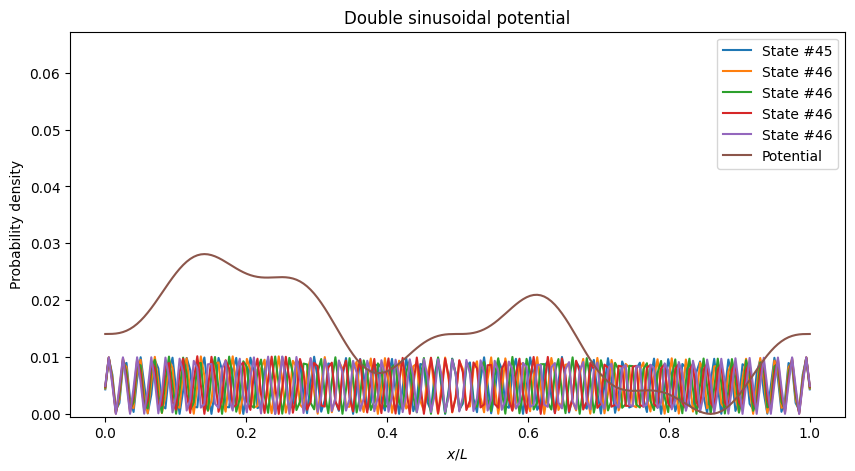

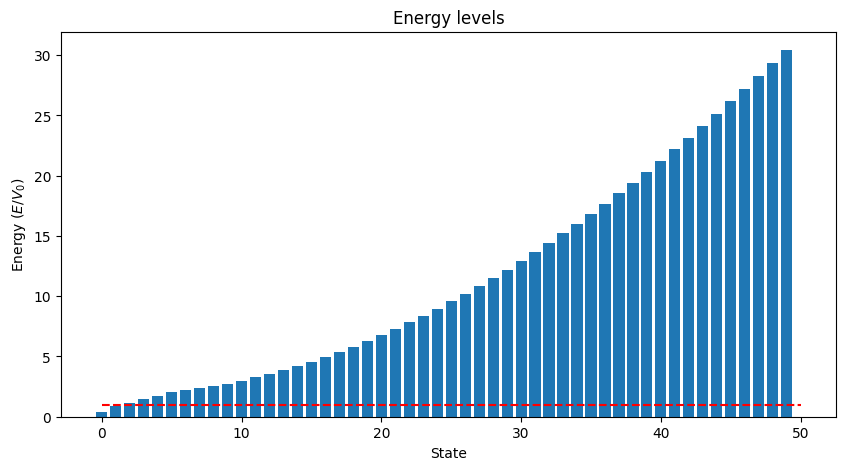

In [241]:
eigenvalues, eigenvectors = compute_eigens(H, k=50)
for index in range(10, len(eigenvalues), 5):
	fig = plt.figure(figsize=(10, 5))
	plt.plot(X, eigenvectors[:, index]**2, label=f'State #{index}')
	plt.plot(X, eigenvectors[:, index+1]**2, label=f'State #{index+1}')
	plt.plot(X, eigenvectors[:, index+2]**2, label=f'State #{index+1}')
	plt.plot(X, eigenvectors[:, index+3]**2, label=f'State #{index+1}')
	plt.plot(X, eigenvectors[:, index+4]**2, label=f'State #{index+1}')
	plt.plot(X, V, label='Potential')
	plt.ylim(-0.0005, np.max(eigenvectors**2)*1.1)
	plt.title('Double sinusoidal potential')
	plt.xlabel('$x/L$')
	plt.ylabel('Probability density')
	plt.legend()
	

eigenenergy_plot(eigenvalues, V_0)

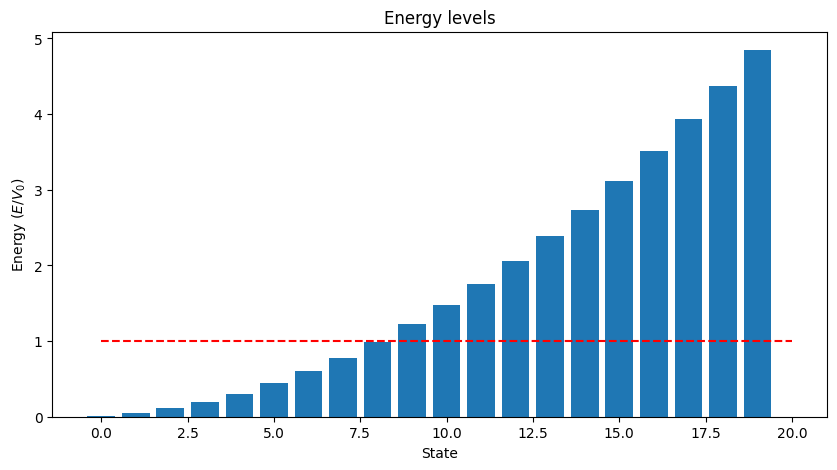

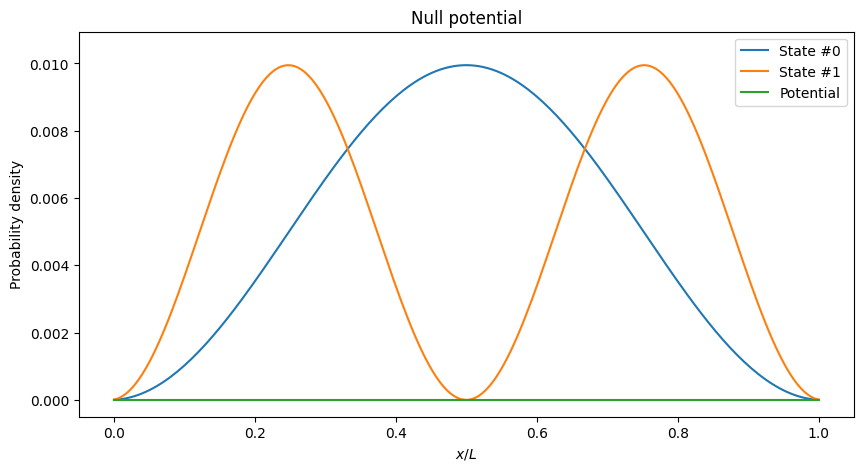

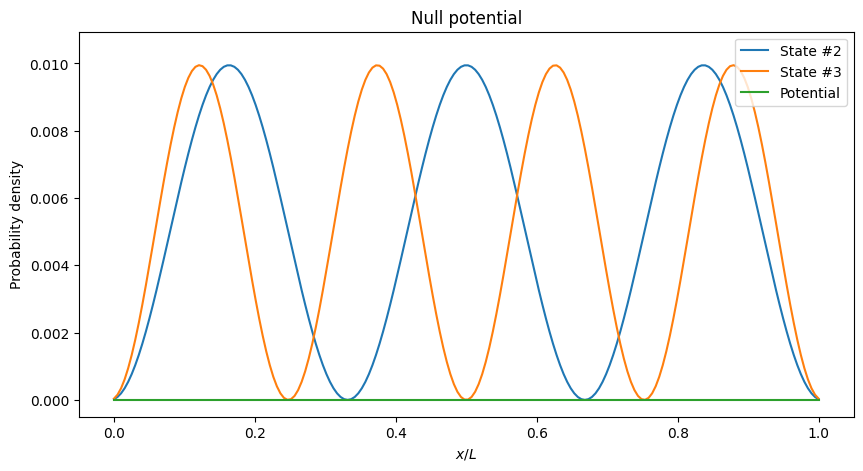

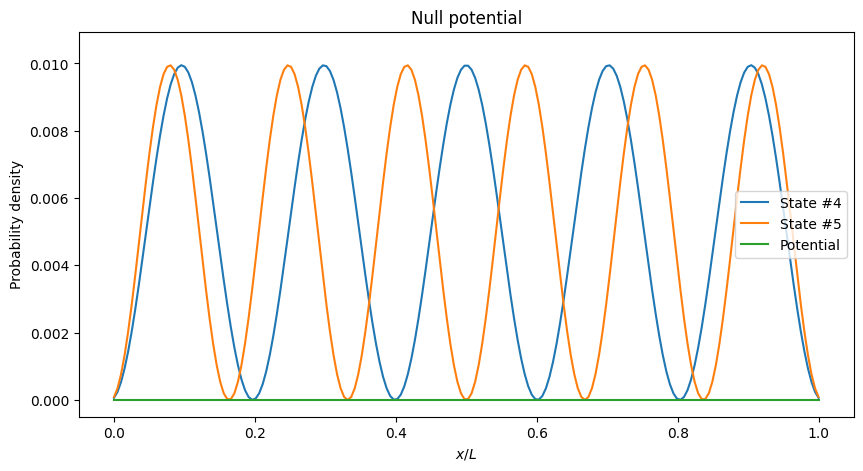

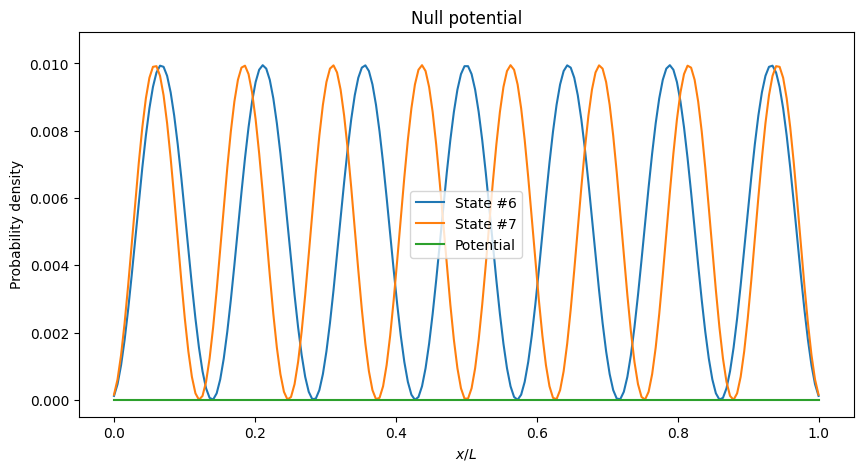

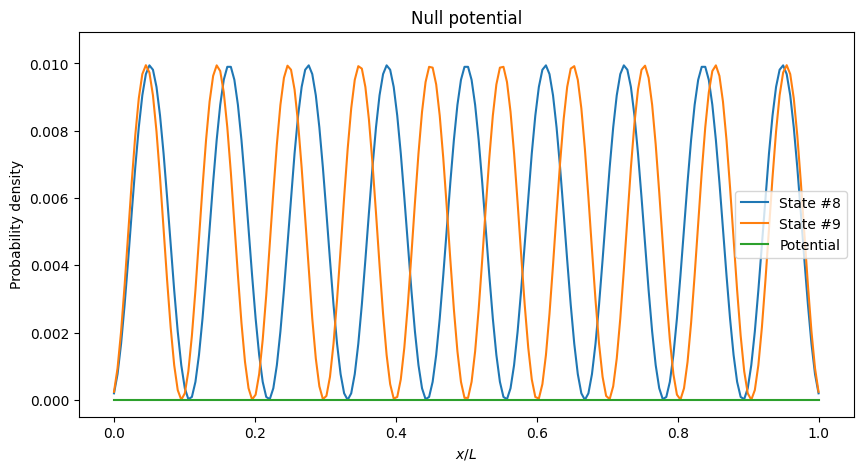

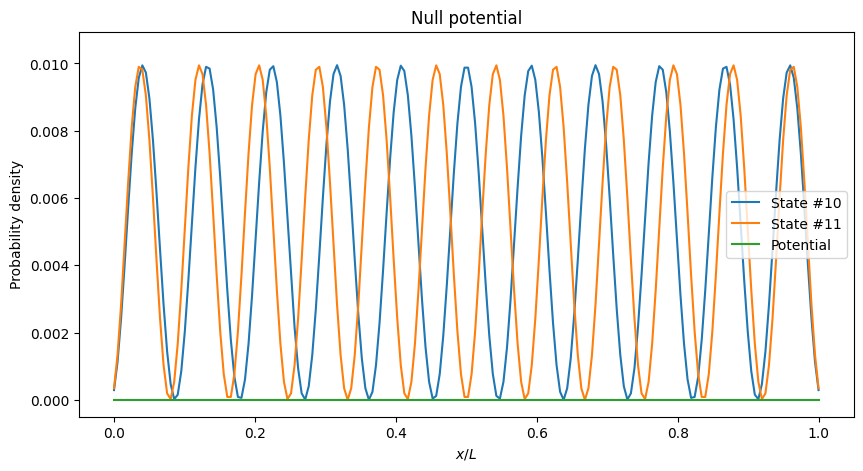

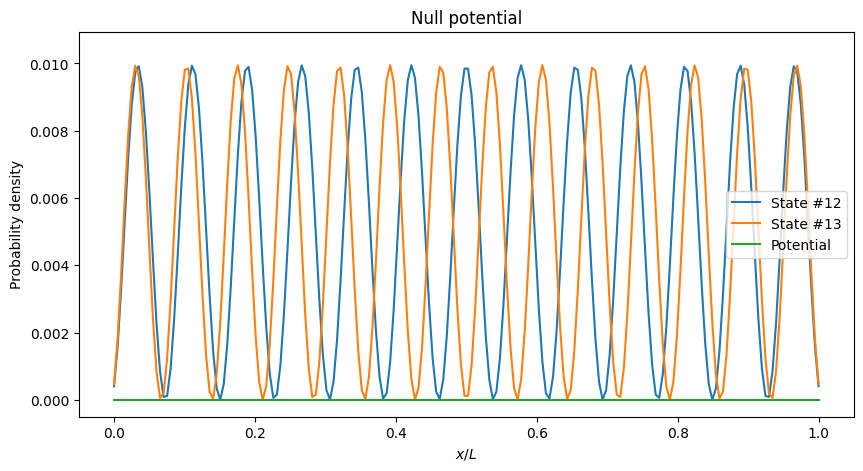

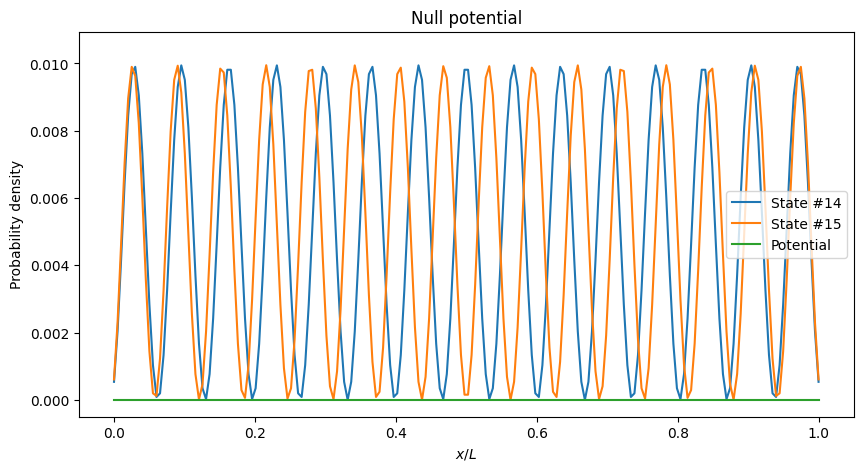

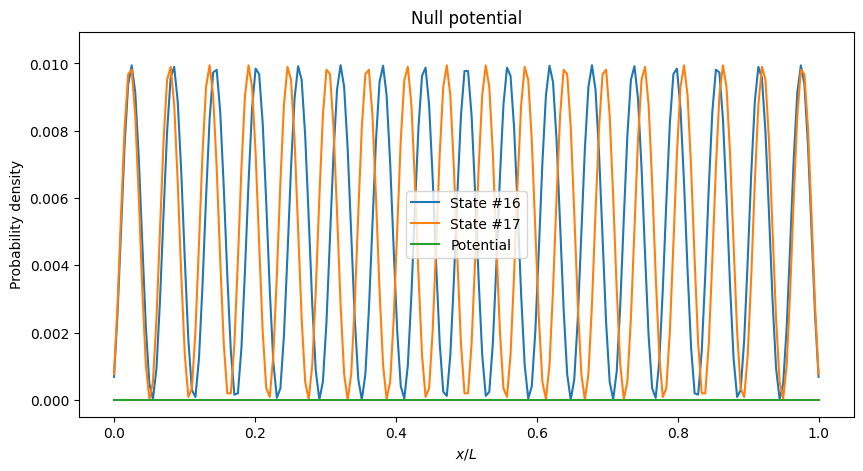

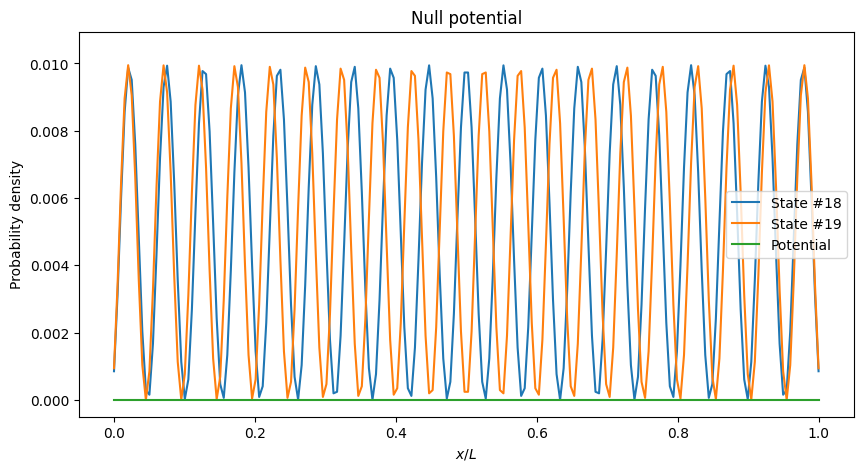

In [244]:
N = 200
V_null = null_potential(N)

H_null = hamiltonian(N, V_null)
eigenvalues_null, eigenvectors_null = compute_eigens(H_null, k=20)

eigenenergy_plot(eigenvalues_null, V_0)

for index in range(0, len(eigenvalues_null), 2):
	fig = plt.figure(figsize=(10, 5))
	plt.plot(X, eigenvectors_null[:, index]**2, label=f'State #{index}')
	plt.plot(X, eigenvectors_null[:, index+1]**2, label=f'State #{index+1}')
	plt.plot(X, V_null, label='Potential')
	plt.ylim(-0.0005, np.max(eigenvectors_null**2)*1.1)
	plt.title('Null potential')
	plt.xlabel('$x/L$')
	plt.ylabel('Probability density')
	plt.legend()

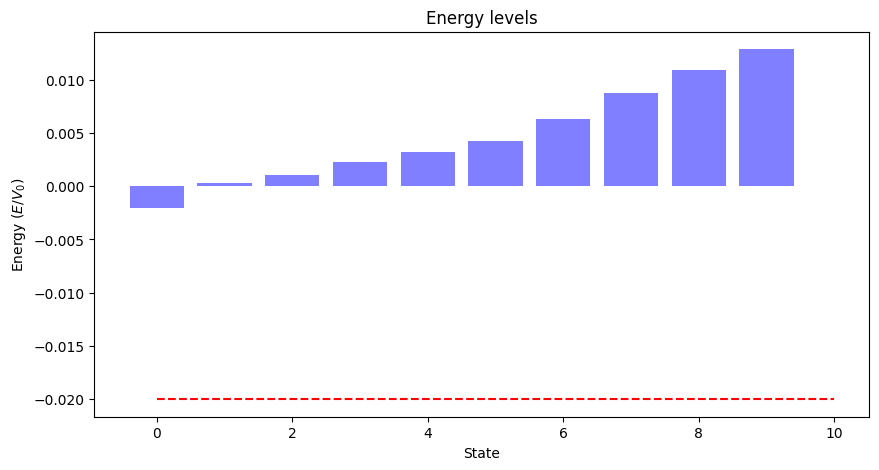

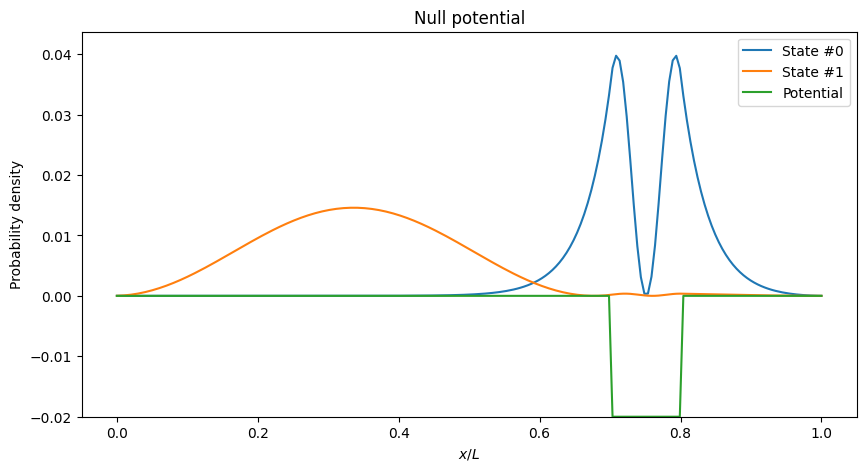

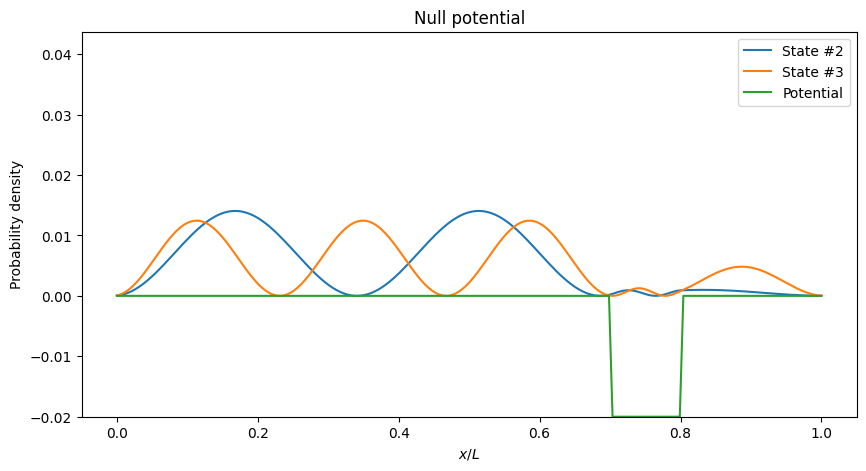

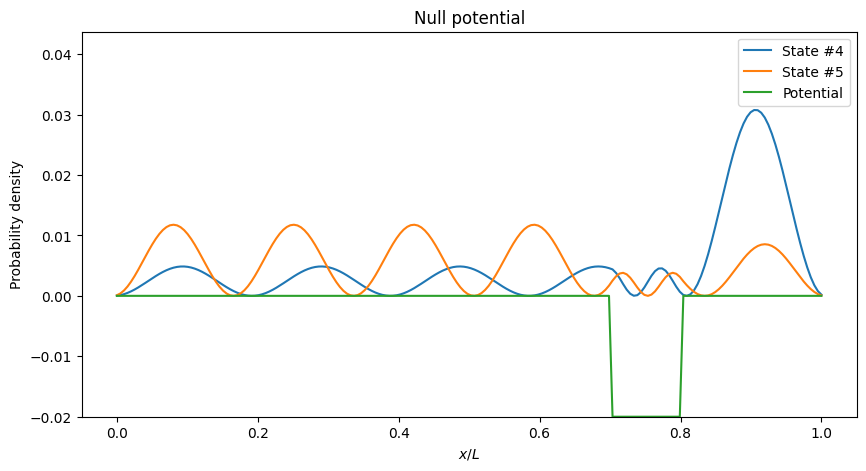

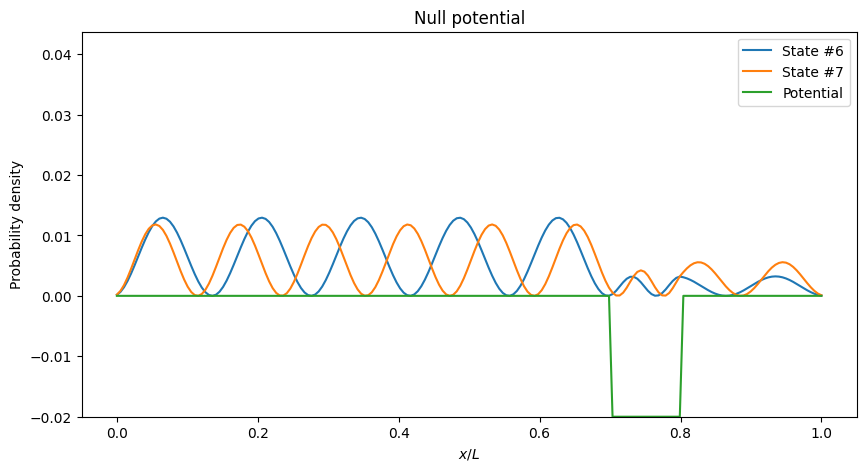

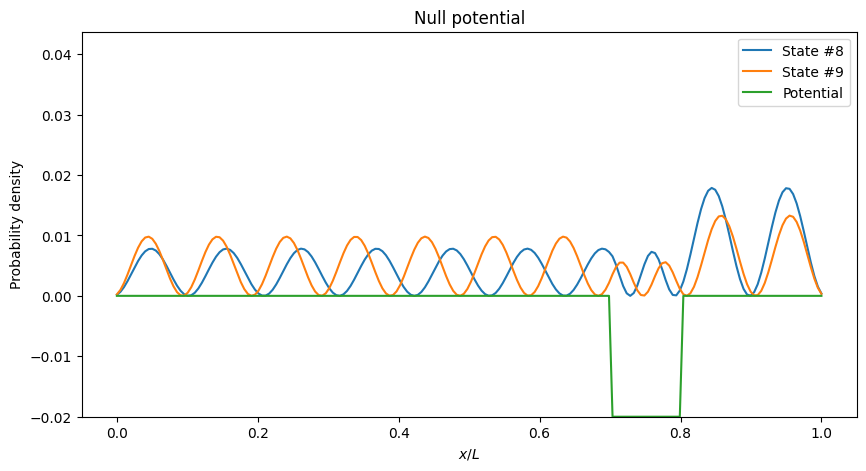

In [263]:
N = 200
V_0 = 0.02
V_well = square_potential(N, intensity=-V_0, pos=(7/10, 8/10))

H = hamiltonian(N, V_well)
eigenvalues, eigenvectors = compute_eigens(H, k=10)

eigenenergy_plot(eigenvalues, 1, -V_0)

for index in range(0, len(eigenvalues), 2):
	fig = plt.figure(figsize=(10, 5))
	plt.plot(X, eigenvectors[:, index]**2, label=f'State #{index}')
	plt.plot(X, eigenvectors[:, index+1]**2, label=f'State #{index+1}')
	plt.plot(X, V_well, label='Potential')
	plt.ylim(np.min(V_well), np.max(eigenvectors**2)*1.1)
	plt.title('Null potential')
	plt.xlabel('$x/L$')
	plt.ylabel('Probability density')
	plt.legend()